# MDP Wavelet

In [1]:
import os
import matplotlib.pyplot as plt
# %matplotlib notebook

import torch
import torch.nn as nn
import torch.nn.functional as F

from pytorch_wavelets import IDWT

In [2]:
from networks.decoders import SparseDecoderWave, DecoderWave, Decoder
from networks.encoders import *

## Build Network

In [3]:
class BaselineModel(nn.Module):
    def __init__(self, opts):
        super(BaselineModel, self).__init__()
        
        decoder_width = 0.5        
        self.encoder = DenseEncoder(normalize_input=opts.normalize_input, pretrained=opts.pretrained_encoder)                       
        self.decoder = Decoder(enc_features=self.encoder.num_ch_enc, decoder_width=decoder_width)        

    def forward(self, x):
        return self.decoder( self.encoder(x) )

class DenseModel(nn.Module):
    def __init__(self, opts):
        super(DenseModel, self).__init__()
        
        decoder_width = 0.5
        self.encoder = DenseEncoder(normalize_input=opts.normalize_input, pretrained=opts.pretrained_encoder)                
        self.decoder = DecoderWave(enc_features=self.encoder.num_ch_enc, decoder_width=decoder_width)        

    def forward(self, x):
        return self.decoder( self.encoder(x) )
    
    
class SparseModel(nn.Module):
    def __init__(self, opts):
        super(SparseModel, self).__init__()
        
        decoder_width = 0.5        
        self.encoder = DenseEncoder(normalize_input=opts.normalize_input, pretrained=opts.pretrained_encoder)        
        self.decoder = SparseDecoderWave(enc_features=self.encoder.num_ch_enc, decoder_width=decoder_width)

    def forward(self, x, thresh_ratio=0.1):
        return self.decoder( self.encoder(x), thresh_ratio)

In [4]:
class Options(object):
    def __init__(self):
        super(Options, self).__init__()        

In [5]:
# Encoder Parameters

opts = Options()


opts.encoder_type = "densenet"
opts.output_scales =  [0, 1, 2, 3]  
opts.normalize_input = True
opts.use_wavelets = True      
opts.pretrained_encoder = False

models = {}

model = DenseModel(opts)
sparse_model = SparseModel(opts)
baseline_model = BaselineModel(opts)

Using Sparse DenseDepth Decoder


### load weights, set to eval()

In [6]:
models_to_load = ["model"]

def load_model(model, load_weights_folder):
    """Load model(s) from disk
    """
    load_weights_folder = os.path.expanduser(load_weights_folder)

    assert os.path.isdir(load_weights_folder), \
        "Cannot find folder {}".format(load_weights_folder)
    print("loading model from folder {}".format(load_weights_folder))    

    n = "model"
    print("Loading {} weights...".format(n))
    path = os.path.join(load_weights_folder, "{}.pth".format(n))
    model_dict = model.state_dict()
    pretrained_dict = torch.load(path, map_location={"cuda:0": "cpu"})
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)    

In [7]:
model_path = "./checkpoints/waveletmonodepth_densenet"
load_model(model, model_path)
model.eval()
print("Done")

print("Loading model weights\t", end="")
load_model(sparse_model, model_path)
sparse_model.eval()
print("Done")

model_path = "./checkpoints/baseline_densenet"
load_model(baseline_model, model_path)
baseline_model.eval()
print("Done")

loading model from folder ./checkpoints/waveletmonodepth_densenet
Loading model weights...
Done
Loading model weights	loading model from folder ./checkpoints/waveletmonodepth_densenet
Loading model weights...
Done
loading model from folder ./checkpoints/baseline_densenet
Loading model weights...
Done


## Data loading

In [8]:
import scipy.io as io
import h5py
import os

from PIL import Image
from data import ToTensor
import numpy as np

nyu_root = "data"
nyu_dataset = h5py.File(os.path.join(nyu_root, "nyu_depth_v2_labeled.mat"), 'r', libver='latest', swmr=True)
splits_idx = io.loadmat(os.path.join(nyu_root, "nyuv2_splits.mat"))["testNdxs"]

def idx2nyu(idx):
    return int(splits_idx[idx])-1

In [9]:
to_tensor = ToTensor()

# Test!

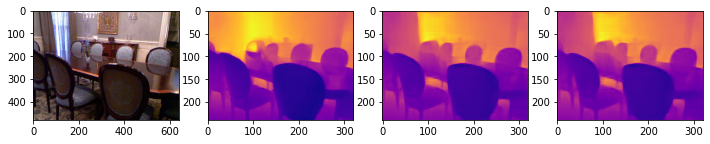

In [15]:
idx = 651
img = nyu_dataset["images"][idx2nyu(idx)].transpose(2,1,0)
depth = nyu_dataset["depths"][idx2nyu(idx)].transpose(1,0)

sample = {"image": Image.fromarray(img), "depth": Image.fromarray((depth*255/10000).astype('int32'))}
sample = to_tensor(sample)
img_tensor = sample["image"].unsqueeze(0)
thresh_ratio = 0.04
with torch.no_grad():
    outputs = model(img_tensor)    
    baseline_outputs = baseline_model(img_tensor)
    sparse_outputs = sparse_model(img_tensor, -10)
    total_ops_dense = sparse_outputs['total_ops']    
    sparse_outputs = sparse_model(img_tensor, thresh_ratio)         
    
plt.figure(figsize=(12,6))
plt.subplot(1,4,1)
plt.imshow(img_tensor[0].permute(1,2,0), cmap="plasma")
plt.subplot(1,4,2)
plt.imshow(baseline_outputs[("disp", 0)][0,0], cmap="plasma")
plt.subplot(1,4,3)
plt.imshow(outputs[("disp", 0)][0,0], cmap="plasma")
plt.subplot(1,4,4)
plt.imshow(sparse_outputs[("disp", 0)][0,0], cmap="plasma")
plt.show()

#### Profiling

In [155]:
from thop import profile, clever_format
from ptflops import get_model_complexity_info

with torch.no_grad():
    feature_maps = baseline_model.encoder(img_tensor)
    macs_all, _ = get_model_complexity_info(baseline_model, tuple(img_tensor.shape[1:]),
                                            as_strings=False, print_per_layer_stat=False, verbose=False)
    macs_encoder, _ = get_model_complexity_info(baseline_model.encoder, tuple(img_tensor.shape[1:]),
                                                as_strings=False, print_per_layer_stat=False, verbose=False)
    macs_decoder, _ = profile(baseline_model.decoder, inputs=(feature_maps, ))

[INFO] Register zero_ops() for <class 'torch.nn.modules.padding.ZeroPad2d'>.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'networks.layers.Conv3x3'>. Treat it as zero Macs and zero Params.
[INFO] Register count_relu() for <class 'torch.nn.modules.activation.LeakyReLU'>.
[INFO] Register count_upsample() for <class 'torch.nn.modules.upsampling.Upsample'>.
[WARN] Cannot find rule for <class 'networks.layers.UpSampleBlock'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'networks.decoders.densedepth_decoder.Decoder'>. Treat it as zero Macs and zero Params.


In [156]:
print("{:<30} {:<8}".format("Baseline (dense) operations", "GFLOPs"))
print("{:<30} {:.3f}".format("Encoder (flops-counter)", macs_encoder / 10**9))
print("{:<30} {:.3f}".format("Decoder (thops) ", macs_decoder / 10**9))
print("{:<30} {:.3f}".format("All (flops-counter) ", macs_all / 10**9))
print("{:<30} {:.3f}".format("Decoder (flops-counter) ", (macs_all - macs_encoder) / 10**9))


print("="*37)
print("{:<30} {:<8}".format("Wavelets version operations", "GFLOPs"))
print("{:<30} {:.3f}".format("Dense operations ", total_ops_dense / 10**9))
print("{:<30} {:.3f}".format("Sparse operations ", sparse_outputs['total_ops'] / 10**9))

Baseline (dense) operations    GFLOPs  
Encoder (flops-counter)        47.854
Decoder (thops)                44.422
All (flops-counter)            92.296
Decoder (flops-counter)        44.442
Wavelets version operations    GFLOPs  
Dense operations               33.464
Sparse operations              20.550


# Visualization

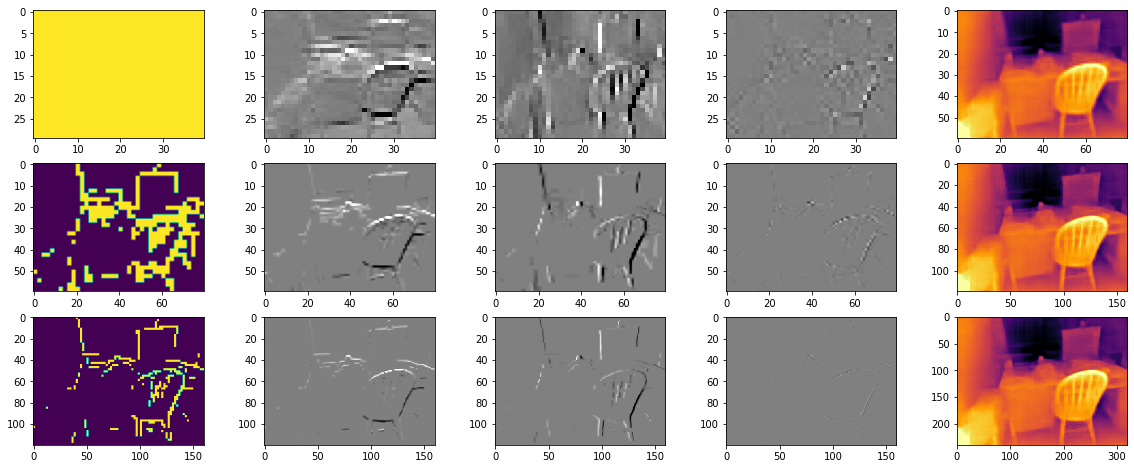

In [157]:
plt.figure(figsize=(20, 8))

def depth_to_disp(depth):
#     disp = np.log(depth)    
    m = depth.min()
    M = depth.max()
    disp = (depth - m) / (M-m)
    return 1-disp

wave_range = 100

for i in range(3):
    plt.subplot(3, 5, 1+5*i)
    plt.imshow(sparse_outputs[('wavelet_mask', 2-i)][0,0])
    plt.clim(0, 1)
    
    coeffs = ["LH", "HL", "HH"]
    for j in range(3):
        plt.subplot(3,5,1+(5*i)+j+1)
        plt.imshow(sparse_outputs[("wavelets", 2-i, coeffs[j])][0,0],
                   vmin=-wave_range/(2**i), vmax = wave_range/(2**i),
                   cmap='gray')        

    plt.subplot(3, 5, 1+(5*i)+4)    
    pred = sparse_outputs[('disp', 2-i)][0,0].numpy()/100
    disp = depth_to_disp(pred)
    plt.imshow(disp, cmap="inferno", vmin = np.percentile(disp, 1), vmax = np.percentile(disp, 99))